In [ ]:
# Define Hurricane damage and exposure files

# hurricane_name = 'Ian'
# exposure_filename = './climada_pyrecodes_examples/climada_inputs/NA_coast_reask_Ian_2022_general.json'
# damage_filename = './climada_pyrecodes_examples/climada_inputs/NA_coast_reask_Ian_2022_loss.json'

hurricane_name = 'Harvey'
exposure_filename = './climada_pyrecodes_examples/climada_inputs/NA_coast_reask_Harvey_2017_general.json'
damage_filename = './climada_pyrecodes_examples/climada_inputs/NA_coast_reask_Harvey_2017_loss.json'


In [2]:
# Find CBSA/MSA where the hurricane made landfall
import geopandas as gpd
from shapely import wkt
import json

def find_candidate_cbsa_indices(building_geom):
    return list(cbsa_sindex.intersection(building_geom.bounds))

# Load building polygons from JSON
with open(exposure_filename) as f:
    exposure = json.load(f)

# Extract building footprints
building_polygons = []
for building_id, building_data in exposure["Buildings"]["Building"].items():
    footprint_str = building_data["GeneralInformation"]["Footprint"]
    try:
        geom = wkt.loads(footprint_str)  # Convert WKT to geometry
        building_polygons.append(geom)
    except Exception as e:
        print(f"Invalid footprint for building {building_id}: {e}")

buildings_gdf = gpd.GeoDataFrame(geometry=building_polygons, crs="EPSG:4326")

# Load CBSA polygons
cbsa_filename = './climada_pyrecodes_examples/CoreBasedStatisticalAreas_USA.geojson'
cbsa_gdf = gpd.read_file(cbsa_filename)  
cbsa_gdf = cbsa_gdf.to_crs("EPSG:4326")  # Ensure same CRS

# Spatial join using sindex for speed
# First, spatial index filter (quick bounding box check)
cbsa_sindex = cbsa_gdf.sindex

# Create a set to store matching CBSA indices
matching_cbsa_indices = set()

# Loop through buildings
for building in buildings_gdf.geometry:
    candidate_indices = find_candidate_cbsa_indices(building)
    for idx in candidate_indices:
        cbsa_poly = cbsa_gdf.geometry.iloc[idx]
        if cbsa_poly.contains(building):
            matching_cbsa_indices.add(idx)

# Filter CBSA GeoDataFrame
matching_cbsa_gdf = cbsa_gdf.iloc[list(matching_cbsa_indices)]

# Get CBSA names from the matched polygons
matching_cbsa_names = matching_cbsa_gdf["NAME"].unique().tolist()

# Print the names
print("Matching CBSA Names:")
for name in matching_cbsa_names:
    print(name)

Matching CBSA Names:
Jacksonville, FL
Jacksonville, NC
Brunswick-St. Simons, GA
Miami-Fort Lauderdale-West Palm Beach, FL
Anderson Creek, NC
Arcadia, FL
Columbia, SC
Palatka, FL
Palm Bay-Melbourne-Titusville, FL
Key West-Key Largo, FL
Wildwood-The Villages, FL
Wilmington, NC
Cape Coral-Fort Myers, FL
Lakeland-Winter Haven, FL
Murrells Inlet, SC
Port St. Lucie, FL
Florence, SC
Myrtle Beach-Conway-North Myrtle Beach, SC
Naples-Marco Island, FL
Deltona-Daytona Beach-Ormond Beach, FL
Laurinburg, NC
Punta Gorda, FL
Charleston-North Charleston, SC
North Port-Bradenton-Sarasota, FL
Ocala, FL
Clewiston, FL
Okeechobee, FL
Lumberton, NC
Orangeburg, SC
Orlando-Kissimmee-Sanford, FL
Hilton Head Island-Bluffton-Port Royal, SC
Homosassa Springs, FL
Sumter, SC
Tampa-St. Petersburg-Clearwater, FL
Savannah, GA
Sebastian-Vero Beach-West Vero Corridor, FL
Sebring, FL


In [3]:
# Get building permit data for matching CBSAs
import random

# Values to be replaced with actual building permit data
building_permit_data = {matching_cbsa_name: random.randint(100, 1000) for matching_cbsa_name in matching_cbsa_names}

In [4]:
# Create pyrecodes input files
import json

def create_locality(locality, cbsa_name, cbsa_polygon, building_permit_data, exposure_filename):
    locality['Coordinates']['WKTPolygon'] = cbsa_polygon.wkt
    locality['Components']['RecoveryResourceSuppliers'][0]['ConstructionIndustry']['Parameters']['Supply'][0]['ConstructionUnit'] = building_permit_data.get(cbsa_name, 0)
    locality['Components']['BuildingStock'][0]['Buildings']['Parameters']['ExposureFile'] = exposure_filename

    return locality

template_component_library_filename = './climada_pyrecodes_examples/pyrecodes_inputs/Template_ComponentLibrary.json'
template_system_configuration_filename = './climada_pyrecodes_examples/pyrecodes_inputs/Template_SystemConfiguration.json'
template_main_filename = './climada_pyrecodes_examples/pyrecodes_inputs/Template_Main.json'

with open(template_system_configuration_filename, 'r') as f:
    system_configuration = json.load(f)

# create localities in the system configuration file for each CBSA
template_locality = system_configuration['Content']['TemplateLocality']
locality_id = 0
for matching_cbsa_index in list(matching_cbsa_indices):
    cbsa_name = cbsa_gdf.iloc[matching_cbsa_index]["NAME"]
    cbsa_polygon = cbsa_gdf.geometry.iloc[matching_cbsa_index]
    locality = template_locality.copy()
    locality = create_locality(locality, cbsa_name, cbsa_polygon, building_permit_data, exposure_filename)
    system_configuration['Content'][cbsa_name + f"-Locality {locality_id}"] = locality
    locality_id += 1

del system_configuration['Content']['TemplateLocality']  # Remove template locality after use

# set the damage file in the system configuration
system_configuration['DamageInput']['Parameters']['DamageFile'] = damage_filename

# save system configuration file
system_configuration_filename = f'./climada_pyrecodes_examples/pyrecodes_inputs/{hurricane_name}_SystemConfiguration.json'
with open(system_configuration_filename, 'w') as f:
    json.dump(system_configuration, f)

# save component library file - no changes needed there for now
with open(template_component_library_filename, 'r') as f:
    component_library = json.load(f)

component_library_filename = f'./climada_pyrecodes_examples/pyrecodes_inputs/{hurricane_name}_ComponentLibrary.json'
with open(component_library_filename, 'w') as f:
    json.dump(component_library, f)

# create main file
with open(template_main_filename, 'r') as f:
    main_template = json.load(f)

main_template['System']['SystemConfigurationFile'] = f'./climada_pyrecodes_examples/pyrecodes_inputs/{hurricane_name}_SystemConfiguration.json'
main_template['ComponentLibrary']['ComponentLibraryFile'] = f'./climada_pyrecodes_examples/pyrecodes_inputs/{hurricane_name}_ComponentLibrary.json'

main_filename = f'./climada_pyrecodes_examples/pyrecodes_inputs/{hurricane_name}_Main.json'
# save main file
with open(main_filename, 'w') as f:
    json.dump(main_template, f)


In [5]:
# Run pyrecodes recovery simulation
from pyrecodes import main

system = main.run(main_file=main_filename)
system.calculate_resilience()

Time step:  0
Time step:  1
Time step:  2
Time step:  3
Time step:  4
Time step:  5
Time step:  6
Time step:  7
Time step:  8
Time step:  9
Time step:  10
Time step:  11
Time step:  12
Time step:  13
Time step:  14
Time step:  15
Time step:  16
Time step:  17
Time step:  18
Time step:  19
Time step:  20
Time step:  21
Time step:  22
Time step:  23
Time step:  24
Time step:  25
Time step:  26
Time step:  27
Time step:  28
Time step:  29
Time step:  30
Time step:  31
Time step:  32
Time step:  33
Time step:  34
Time step:  35
Time step:  36
Time step:  37
Time step:  38
Time step:  39
Time step:  40
Time step:  41
Time step:  42
Time step:  43
Time step:  44
Time step:  45
Time step:  46
Time step:  47
Time step:  48
Time step:  49
Time step:  50
Time step:  51
Time step:  52
Time step:  53
Time step:  54
Time step:  55
Time step:  56
Time step:  57
Time step:  58
Time step:  59
Time step:  60
Time step:  61
Time step:  62
Time step:  63
Resilience assessment finished.
Re-CoDeS Resilienc

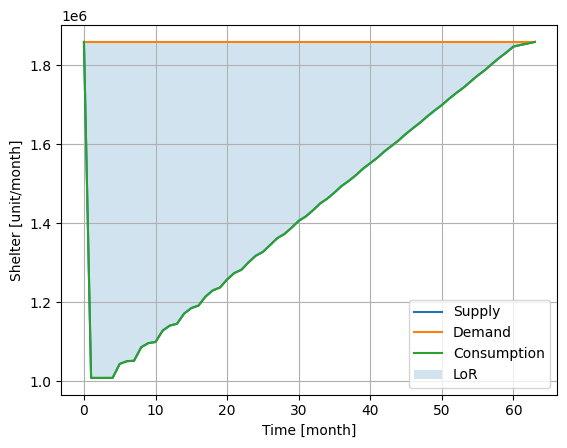

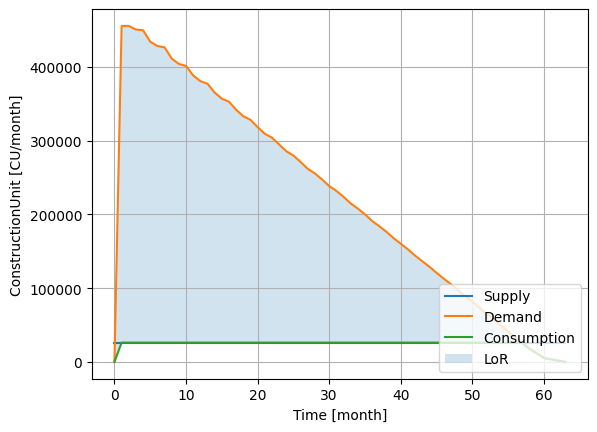

In [6]:
# Plot results
from pyrecodes.plotter.concrete_plotter import ConcretePlotter

plotter_object = ConcretePlotter()
resources_to_plot = ['Shelter', 'ConstructionUnit']
units = ['[unit/month]', '[CU/month]']
plotter_object.plot_supply_demand_dynamics(system, resources_to_plot, units, x_axis_label='Time [month]')


In [ ]:
# Validate employment data
pass